In [30]:
import matplotlib
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import inset_locator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from rasterio import features
from affine import Affine
import xarray as xr
from percent_mean_change import rasterize

In [7]:
#Get NRM shapes with geopandas
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
f = geopandas.read_file("/home/548/ab4502/working/NRM_super_clusters/NRM_super_clusters.shp")
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]

[0] logit -6.13650088040307
[0] dcp -5.418505394126016
[0] t_totals -29.301135083978085
[0] eff_sherb -10.742784638179655


[1] logit -5.377343745706374
[1] dcp 0.2940543384159528
[1] t_totals -12.771026575649325
[1] eff_sherb -1.1326060773784081


[2] logit -11.83804642899886
[2] dcp -3.01824386288492
[2] t_totals -10.006554031405212
[2] eff_sherb -2.7939668950099468


[3] logit -2.2773698105457805
[3] dcp 1.6168241806588324
[3] t_totals -3.7201267121320982
[3] eff_sherb 0.4553585164646973


[0, 1, 2, 3] dcp 0.5455250679816167


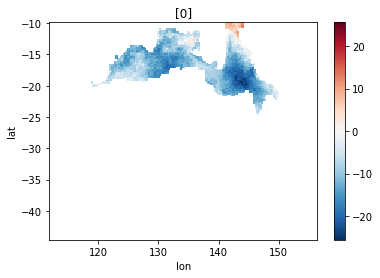

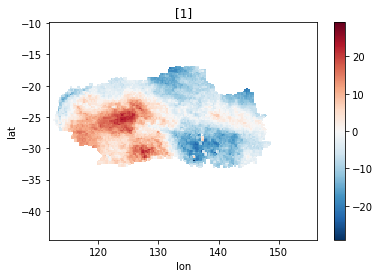

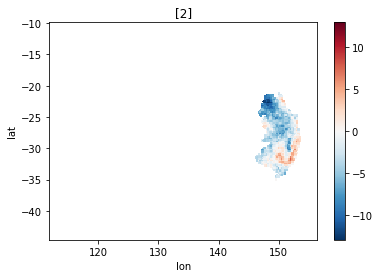

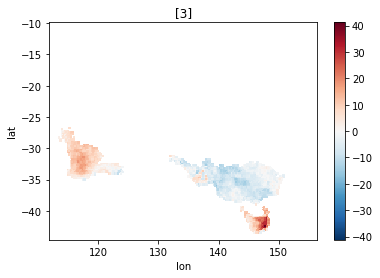

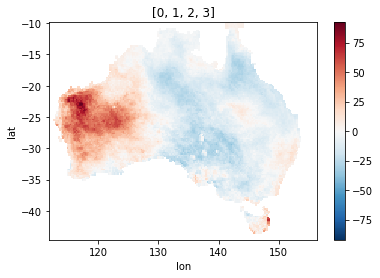

In [64]:
def nrm_change(var, thresh, n, plot=False, m=False):
        era5_t1 = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/era5_"+var+"_6hr_"+thresh+"*daily.nc", concat_dim="time"
        , combine="by_coords")[var].sel({"time":slice("1979-01-01","1998-12-01")})
        era5_t2 = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/era5_"+var+"_6hr_"+thresh+"*daily.nc", concat_dim="time"
        , combine="by_coords")[var].sel({"time":slice("1999-01-01","2018-12-01")})
        
        if m:
            era5_t1 = era5_t1.sel({"time":np.in1d(era5_t1["time.month"],m)}).sum("time") / len(np.unique(era5_t1["time.year"]))
            era5_t2 = era5_t2.sel({"time":np.in1d(era5_t2["time.month"],m)}).sum("time") / len(np.unique(era5_t2["time.year"]))             
        else:
            era5_t1 = era5_t1.sum("time") / len(np.unique(era5_t1["time.year"]))
            era5_t2 = era5_t2.sum("time") / len(np.unique(era5_t2["time.year"]))        

        era5_t1["nrm"] = rasterize(shapes, era5_t1.coords)
        era5_t2["nrm"] = rasterize(shapes, era5_t2.coords)
        
        t1_reg = xr.where(era5_t1["nrm"].isin(n), era5_t1, np.nan)
        t2_reg = xr.where(era5_t2["nrm"].isin(n), era5_t2, np.nan)

        change = (t2_reg-t1_reg)/t1_reg * 100
        
        if plot:
            plt.figure()
            change.plot()
            plt.title(n)
        
        print(n, var, np.nanmean(change.values))

for n in [[0], [1], [2], [3]]:
    nrm_change("logit", "is_conv_aws", n)    
    nrm_change("dcp", "0.15", n)
    nrm_change("t_totals", "48.1", n)
    nrm_change("eff_sherb", "0.47", n, True)
    print("\n")
    
nrm_change("dcp", "0.15", [0,1,2,3], plot=True, m=[9,10,11])